In [40]:
# Robust portfolio comparison
# Based on Stanford ee364b lecture notes and convex optimization book
import matplotlib.pyplot as plt
import cvxpy as cp
import numpy as np
np.random.seed(0)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica Neue"],
    "font.size": 28,
})

In [73]:
np.random.seed(1)
n = 200
mu = 1.05 + 0.3 * np.linspace(1, 1 / n, n)
u_max = 0.05 + 0.6 * np.linspace(1, 1 / n, n)  # Uncertainty sets
u_max[-1] = 0  # Cash no variability
epsilon = 1e-3  # Risk parameter (probability of failure)
alpha = 1.1  # Unwanted return level

In [74]:
# Nominal and conservative allocations
x_nom = np.zeros(n); x_nom[0] = 1 # Nominal solution (best average return)
x_con = np.zeros(n); x_con[n-1] = 1 # Conservative solution (only cash)

In [75]:
# Robust allocation
x = cp.Variable(n)
objective = mu @ x
constraints = [mu @ x - np.sqrt(.5 * np.log(1/epsilon)) * cp.norm(np.diag(2 * u_max) @ x, 2) >= alpha,
               cp.sum(x) == 1, x >= 0]
problem = cp.Problem(cp.Maximize(objective), constraints)
problem.solve()
x_rob = x.value

In [80]:
# Simulate returns
num_samples = 2 * 10**5
returns_nom = np.zeros(num_samples)
returns_con = np.zeros(num_samples)
returns_rob = np.zeros(num_samples)
prob_loss = 0

for sample in range(num_samples):
    r = mu + u_max * (1 - 2 * np.random.rand(n))
    returns_nom[sample] = r @ x_nom
    returns_con[sample] = r @ x_con
    returns_rob[sample] = r @ x_rob
    prob_loss += (r @ x_rob <= alpha)/num_samples


# Empirical probability of unwanted loss
print("Empirical probability of unwanted loss: %.5f, epsilon=%.5f" % (prob_loss, epsilon))

Empirical probability of unwanted loss: 0.00000, epsilon=0.00100


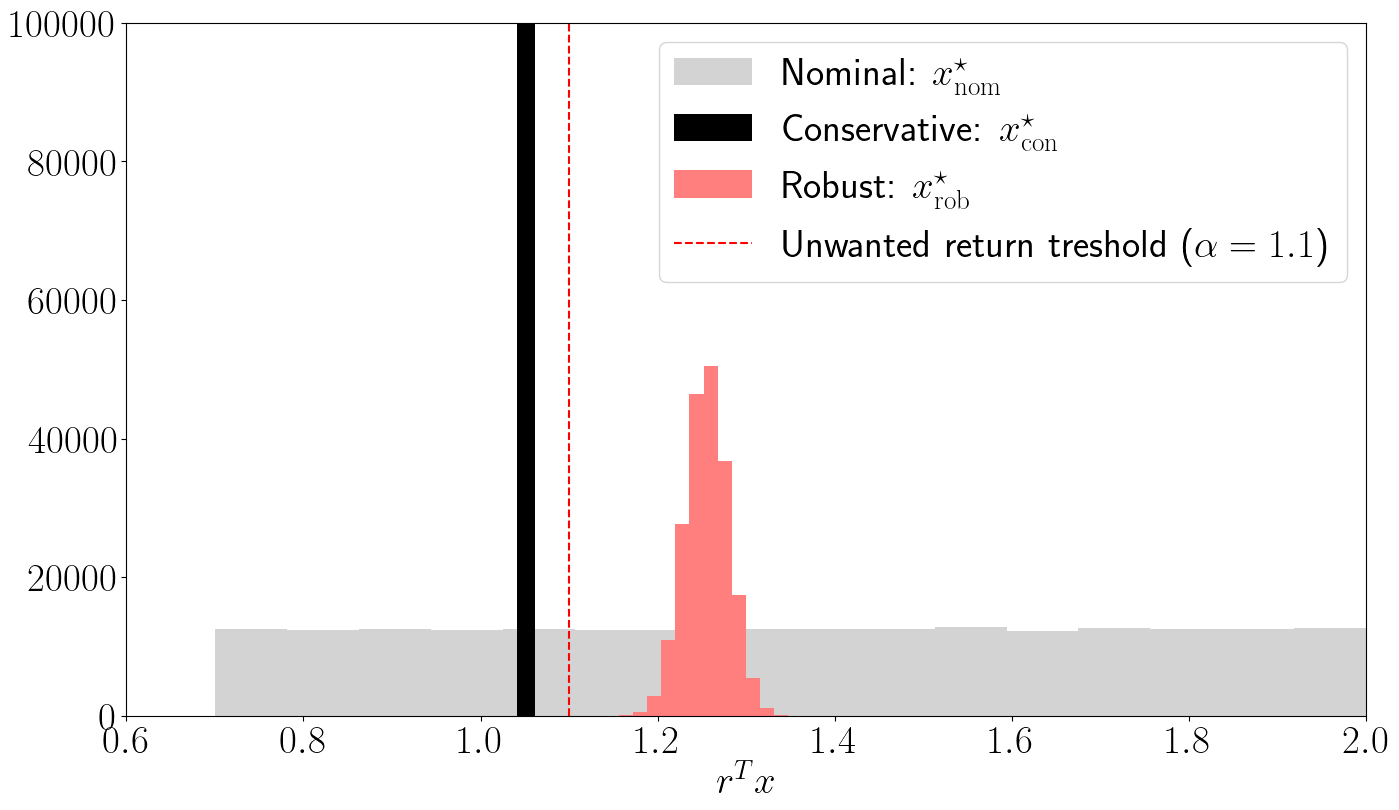

In [79]:
# Plot results
fig, ax = plt.subplots(figsize=(16, 9))
plt.hist(returns_nom, bins=16, color='lightgray', label=r"Nominal: $x^\star_{\rm nom}$")
plt.hist(returns_con, bins=[mu[-1] - 1e-2, mu[-1] + 1e-2], color='black', label=r"Conservative: $x^\star_{\rm con}$")
plt.hist(returns_rob, bins=14, color='#FF7F7F', label=r"Robust: $x^\star_{\rm rob}$")
plt.axis([0.6, 2, 0, num_samples / 2])
plt.axvline(x=alpha, color='red', linestyle='--', label=r'Unwanted return treshold ($\alpha = %.1f$)' % alpha)
plt.legend()
plt.xlabel(r"$r^Tx$")
plt.savefig("portfolio.pdf", bbox_inches="tight")